In [46]:
import numpy as np
import numpy.random as np_rand
import scipy.special as sc
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from scipy.io import arff
from numpy.lib.recfunctions import structured_to_unstructured
from timeit import default_timer


## Simulated data

In [47]:
# Define parameters
k = 20 # truncation level for truncated drichlet process
alpha = 5 # concentration parameter for DP
n_samples = 100 # Number of X sample points to generate
num_of_gaussian_dim = 2 # Number of dimensions in Gaussian distribution from which X will be sampled
rho = 0.8 # first-order autocorrelation coefficient for covariance matrix of Gaussian distribution from which X will be sampled
variance_prior = 100 # variance of Gaussian baseline distribution in DP
variance_sample = 4 # variance of the gaussion from which X will be sampled


In [48]:
# Generate the baseline 2-dim Gaussion distribution prior of DP
base_mean = np.zeros(num_of_gaussian_dim) # zero-mean Gaussian
base_cov = np.eye(num_of_gaussian_dim) * variance_prior # scaled for comparison across dimensions (values should be of similar order)

#base_cov = [[100, 0], [0, 100]]
print("base_mean: \n", base_mean)
print("base_cov: \n", base_cov)

base_mean: 
 [0. 0.]
base_cov: 
 [[100.   0.]
 [  0. 100.]]


In [49]:
# Generate eta from baseline distribution of DP (Unique values of means(each per dim) from the 2-dim gaussion prior distribution of DP)
eta_params = np_rand.multivariate_normal(base_mean, base_cov, size=k)
#means = norm.rvs(base_mean, base_cov) # draw normal random variables for means
print("eta_params:\n", eta_params)

eta_params:
 [[  5.82073948   3.03332301]
 [ -3.6435401  -12.20866518]
 [  6.0265345   -2.55987585]
 [-13.58122763  -3.61765562]
 [ -5.48361948  15.54340594]
 [ 15.18924063 -10.63568398]
 [ -6.19244871  -6.15728852]
 [-21.01243488 -26.65801833]
 [ -9.94262688  22.24418132]
 [ -3.37421609  16.14320576]
 [ 19.97230996  -6.66942533]
 [ 19.79720252   1.79923791]
 [ -3.23106326  21.8887822 ]
 [ 14.68347085  -7.57036063]
 [  3.037188     0.47707339]
 [ -5.49435881  -2.23219135]
 [ -4.20209171  17.0007753 ]
 [  4.3784614  -16.42648759]
 [ 10.52742409  -3.03031496]
 [ 10.26130785  12.06927384]]


In [50]:
# DP using stick-breaking technique
V_params = np_rand.beta(1, alpha, size=k)
V_params[k-2] = 1 #Truncate DP construction at K by setting V_K-1 = 1, but in our case k index start from 0
print("V_params:\n ", V_params)

theta_params = np.zeros(k) # initialize the theta_params
remaining_stick = 1 # initialize the remaining stick length
for i in range(k):
    theta_params[i] = V_params[i] * remaining_stick # break the stick
    remaining_stick *= (1 - V_params[i]) # update the remaining stick length
print("theta_params:\n ", theta_params)

V_params:
  [0.19886541 0.04277731 0.41845105 0.07199459 0.23054527 0.22770328
 0.24720081 0.11209632 0.03385928 0.08172699 0.01318704 0.25518554
 0.03074446 0.27308454 0.11295216 0.15777349 0.02513689 0.13746362
 1.         0.22996145]
theta_params:
  [0.19886541 0.03427039 0.32089513 0.03210736 0.09541386 0.07251162
 0.06079564 0.02075358 0.00556603 0.01297996 0.00192321 0.03672575
 0.00329556 0.02837253 0.0085306  0.01056978 0.00141831 0.00756123
 0.04744406 0.        ]


In [51]:
# Generate the first-order autocorrelation fixed covariance matrix of Gaussian distribution from which X will be sampled
cov = np.zeros((num_of_gaussian_dim, num_of_gaussian_dim)) # initialize the covariance matrix
for i in range(num_of_gaussian_dim):
    for j in range(num_of_gaussian_dim):
            cov[i, j] = variance_sample*(rho ** abs(i - j)) # assign the value based on the distance

#cov = [[3, 0.95], [0.95, 3]]
print('cov matrix: \n', cov)

cov matrix: 
 [[4.  3.2]
 [3.2 4. ]]


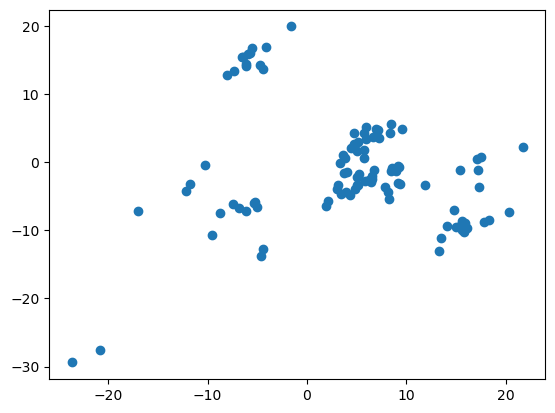

In [52]:
# Generate the samples from the Gaussion-Gaussion distribution
samples = np.zeros((n_samples, num_of_gaussian_dim)) # initialize the data matrix
z_params = np.zeros(n_samples, dtype=int) # initilize the z parameter

for i in range(n_samples):
    z_params[i] = np_rand.choice(k, p=theta_params) # assign a cluster to each sample point
    samples[i] = np_rand.multivariate_normal(eta_params[z_params[i]], cov) # draw a Sample point from the assigned cluster

# print("Samples: \n", samples)
plt.scatter(samples[:,0],samples[:,1])

In [53]:
import itertools
import matplotlib as mpl
from scipy import linalg

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, title):
    """
    Plot gaussian components as ellipses
    """
    splot = plt.subplot(1, 1, 1)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        # covar = np.diag(covar)
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.title(title)

In [54]:
# The scipy BGM do not provide a variance-fixed gaussian component option. 
bgm = BayesianGaussianMixture(n_components=k, weight_concentration_prior=None, n_init=1, covariance_type="full", max_iter=1000, verbose=2)
bgm.fit(samples)

Initialization 0
  Iteration 10	 time lapse 0.03301s	 ll change 1.30854
  Iteration 20	 time lapse 0.01900s	 ll change 0.12994
Initialization converged: True	 time lapse 0.06100s	 ll -650.16779


BayesianGaussianMixture(max_iter=1000, n_components=20, verbose=2)

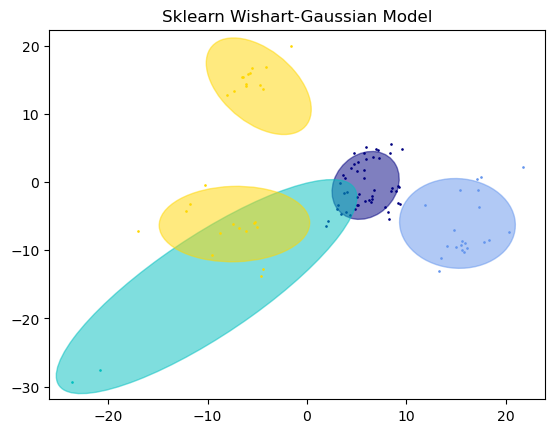

In [55]:
plot_results(samples, bgm.predict(samples), bgm.means_, bgm.covariances_, "Sklearn Wishart-Gaussian Model")

Converge at iter 83
ELBO = -1357.2055691380885


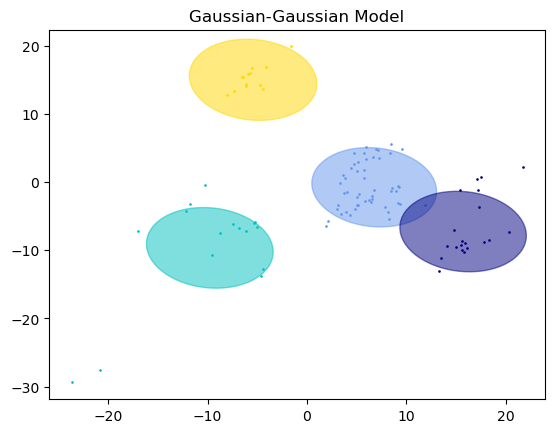

In [56]:
# Our model assume a fixed covariance in each component
from dp import *

eps = 1e-3
cov_samples = np.cov(samples.T)
mu_samples = np.mean(samples, axis=0)

# Initialization
Sigma = cov_samples / k ** 0.5 # Covariance matrix of each component
Sigma0 = cov_samples # Baseline covariance
dp = DpGaussian(samples, alpha=1 / k, Sigma=Sigma, mu0=mu_samples, Sigma0=Sigma0, K=k)
elbo = - np.inf

# CAVI update
for i in range(100):
    prev_elbo = elbo
    dp.update()
    elbo = dp.elbo()
    if elbo - prev_elbo < eps:
        print("Converge at iter", i)
        break

print("ELBO =", elbo)
prob = dp.predict(samples)
label = np.argmax(prob, axis=1)
plot_results(samples, label, dp.mu_p, dp.Sigma + dp.Sigma_p, "Gaussian-Gaussian Model")

In [57]:
from scipy.special import logsumexp

M = 51

def plot_contour(model: DpGaussian, x, x_min, x_max, y_min, y_max):
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, M), np.linspace(y_min, y_max, M))
    xy = np.stack((xv, yv), axis=-1).reshape((M * M, 2))
    
    prob = logsumexp(model.predict(xy), axis=1)
    z = np.reshape(prob, (M, M))

    plt.figure()
    plt.scatter(x[:, 0], x[:, 1], 0.8)
    plt.contour(xv, yv, z)
    plt.show()
    

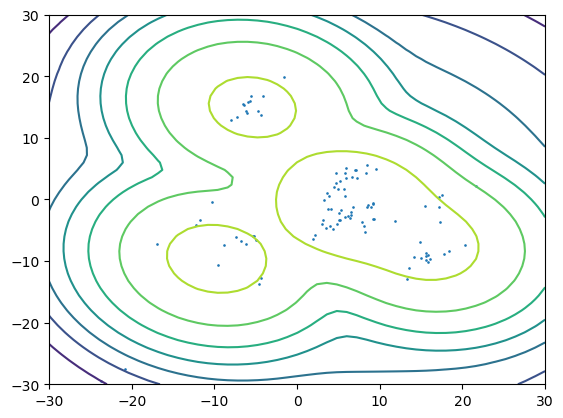

In [58]:
plot_contour(dp, samples, -30, 30, -30, 30)